# Different Solutions for 1-Dimensional-1-Phase Problem

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1-5ztISn_pEuNjBWLEckyimFk1pDJf9wc/view?usp=drive_link&target=_blank)

*Author: Zakariya Abugrin | Date: May 2025*

In [1]:
# Colab only:
try:
    # Install reservoirflow in Colab
    import os
    import google.colab
    !pip install reservoirflow
    # Restart session after installation
    os.kill(os.getpid(), 9)
    print("Session was restarted.")
    print("Now you can run to the following cells.")
except ImportError:
    pass

## Introduction

The solution for a simple 1-dimensional-1-phase (1D1P) problem is available in all solutions which includes: `analytical`, `numerical`, `neurical`. In tutorial, we will see how we can build all solutions and compare them together. 

## Prerequisites:
Before you can follow this tutorial, you need to understand the following tutorials:
1. [Understand scalers Module](/user_guide/tutorials/tutorial_understand_scalers_module.html).
2. [Understand Compiling](/user_guide/tutorials/tutorial_understand_compiling.html).

## Import `reservoirflow`

We start with importing `reservoirflow` as `rf`. The abbreviation `rf` refers to `reservoirflow` where all modules under this library can be accessed. `rf` is also used throughout the [API](/api/API.html) documentation. We recommend our users to stick with this convention.

In [2]:
import reservoirflow as rf
import numpy as np

print(rf.__version__)

0.1.0b3


## Build a model

A reservoir simulation model requires two objects: `Grid` and `Fluid`. The function below `create_model()` starts by creating these objects which are used to initiate a `Model` object using [`BlackOil`](/api/reservoirflow.models.BlackOil.html) class. 

In [3]:
def create_model(nx=101, n_w=2, comp=False):
    # Compressibility:
    if comp:
        g_comp = 1 * 10**-6
        f_comp = 1 * 10**-5
    else:
        g_comp = None
        f_comp = None
    # Grid:
    grid = rf.grids.RegularCartesian(
        nx=nx,
        ny=1,
        nz=1,
        dx=300,
        dy=350,
        dz=40,
        phi=0.27,
        kx=270,
        comp=g_comp,
        dtype="double",
    )
    # Fluid:
    fluid = rf.fluids.SinglePhase(
        mu=0.5,
        B=1,
        comp=f_comp,
        dtype="double",
    )
    # Model:
    model = rf.models.BlackOil(
        grid, fluid, pi=4000, dtype="double", dt=1, verbose=False
    )
    # Wells:
    if n_w > 0:
        well_ids = np.cumsum([nx // (n_w + 1) for i in range(n_w)])
        print("Wells_ids:", well_ids)
        for well_id in well_ids:
            # model.set_well(id=well_id, q=-600, s=1.5, r=3.5)
            model.set_well(id=well_id, pwf=1000, s=1.5, r=3.5)
        # Boundaries:
        model.set_boundaries({
            0: ("pressure", 4000),  # left boundary
            nx + 1: ("pressure", 4000), # right boundary
            })
    else:
        # Boundaries:
        model.set_boundaries({
            0: ("pressure", 4000), # left boundary
            nx + 1: ("pressure", 1000), # right boundary
            })

    return model

In [4]:
model = create_model(n_w=0, comp=True)
print("Current solutions:", model.solutions)

Current solutions: {}


```{note}
When a model is created, compiled solutions are made available under the dictionary ``model.solutions`` after executed (i.e. ``model.run()``). The model always switches to the latest compiled solution. To change to previous solutions, ``model.set_solution()`` can be used with the solution names same as shown in the dictionary ``model.solutions``.
```

In [5]:
model.solutions # Gives empty dictionary, as no solution was computed yet.

{}

## Define Scalers

In [6]:
model.scalers_dict  # model.get_scalers()

{'time': ['MinMax', (0, 1)],
 'space': ['MinMax', (-1, 1)],
 'pressure': ['MinMax', (-1, 1)],
 'rate': [None, None]}

## Compile the model

Before you can run the model, you need to compile a solution for it. By compiling a solution, you actually decide the solution you want to use for your model. Interestingly, `reservoirflow` provides multiple solutions for the same model based on your configuration, see [Understand Compiling](/user_guide/tutorials/tutorial_understand_compiling.html).


In [7]:
# Run configuration
run_config = dict(
    nsteps=100,
    threading=True,
    vectorize=True,
    check_MB=True,
    print_arrays=False,
    isolver=None,  #'cgs',
)

### Analytical Solution


Analytical solution of the homogeneous PDE with nonhomogeneous BC:

[](reference) <!-- (ch04_homogeneousPDE_nonhomogeneousBC_12) -->

$
u(x,t) = u_0 + \frac{u_L - u_0}{L}x +
\frac{2}{\pi} \, \sum_{n=1}^{\infty}
\biggr[(u_i - u_0)\frac{1}{n} + (u_L-u_i)\frac{(-1)^n}{n} \biggr ] \,
\sin(\frac{n \pi x}{L}) \, e^{-{\frac{n^2 \pi^2}{L^2}} \alpha t} 
\qquad \text{where} \quad n \in \mathbb{N}
$

This solution can be obtained as following

[info] D1P1 was assigned as model.solution.
[info] Simulation run started: 100 timesteps.


[step] 200: 100%|██████████| 200/200 [00:00<00:00, 642.33steps/s]


[info] Simulation run of 100 steps finished in 0.32 seconds.
[Info] Case: Analytical (N=200) was added.


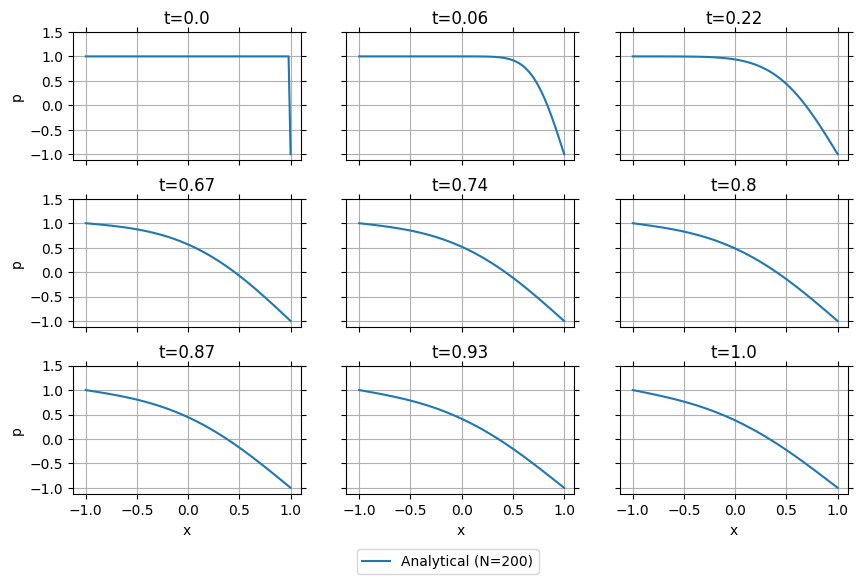

In [8]:
N = 200 # Number of iterations (the higher the better)
model.compile("analytical", "1D1P", True, f'Analytical (N={N})')
model.run(**{"N": N} | run_config)
model.plot_solution(True, True)

### Numerical Solution


Numerical solution based on Finite-Difference-Method can be accessed using ``FDM`` module.

This solution can be obtained as following:

In [9]:
model.compile("numerical", "FDM", True, "Numerical (Nx=101)")
print("Compiler:", repr(model.compiler))
print("Solution:", repr(model.solution))

[info] FDM was assigned as model.solution.
Compiler: rf.solutions.Compiler(model='BlackOil', stype='numerical', method='FDM', sparse=True)
Solution: rf.solutions.Solution(name='Numerical (Nx=101)')


In [10]:
boundary = True
scale = False

df = model.get_df(
    columns=["time", "cells_pressure"],
    boundary=boundary,
    units=False,
    melt=True,
    scale=scale,
    drop_zero=False,
    drop_nan=False,
)
df

,id,Step,x,Time,P
0,0,0,150.0,0,4000.0
1,1,0,450.0,0,4000.0
2,2,0,750.0,0,4000.0
3,3,0,1050.0,0,4000.0
4,4,0,1350.0,0,4000.0
...,...,...,...,...,...
98,98,0,29550.0,0,4000.0
99,99,0,29850.0,0,4000.0
100,100,0,30150.0,0,4000.0
101,101,0,30450.0,0,4000.0


In [11]:
shape = model.get_shape(boundary)
fdir = list(model.grid.get_fdir())
ncols = len(fdir) + 2  # +2 for time and P
values = df[["Time", *fdir, "P"]].values.reshape(*shape, ncols)
X, Y = values[:, :, :2], values[:, :, 2]



In [12]:
[0, 1, 5, 10, 40, 50, 60, 90, 100]

def get_custom_sampled_array(input_array):
    """
    Selects 9 values from a 1D NumPy array based on predefined relative
    proportions, ensuring the first and last elements are always included.

    The relative proportions are derived from the example indices
    [0, 1, 5, 10, 40, 50, 60, 90, 100] for an array of length 101.

    Parameters:
    -----------
    input_array : np.ndarray
        The 1D NumPy array from which to select values.

    Returns:
    --------
    np.ndarray
        A 1D array containing the 9 selected values.
        If the input array has fewer than 9 elements, some values
        in the output array might be duplicates.
    """
    if input_array.ndim != 1:
        raise ValueError("Input array must be 1-dimensional.")

    num_elements = len(input_array)

    if num_elements == 0:
        return np.array([])
    if num_elements == 1:
        # If only one element, repeat it 9 times as per the requirement of 9 values
        return np.array([input_array[0]] * 9)

    # Define the target relative positions (proportions)
    # These are derived from: [0, 1, 5, 10, 40, 50, 60, 90, 100] / 100
    # where 100 is the max index for a length of 101.
    relative_positions = np.array(
        [0.0, 0.01, 0.05, 0.1, 0.4, 0.5, 0.6, 0.9, 1.0]
    )

    # Calculate the maximum possible index for the current array length
    max_index = num_elements - 1

    # Scale the relative positions to the current array's index range
    # and round to the nearest integer to get the actual indices.
    selected_indices_float = relative_positions * max_index
    selected_indices = np.round(selected_indices_float).astype(int)

    # Ensure indices are within valid bounds (0 to max_index)
    # This is a safety measure, but for proportions 0.0-1.0 and np.round,
    # the endpoints should naturally be correct.
    selected_indices = np.clip(selected_indices, 0, max_index)

    # Select the values from the input array using the calculated indices
    return selected_indices

get_custom_sampled_array(values[:, 0, 0])

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
values[:, 0, 0]

array([0.])

In [14]:
np.set_printoptions(precision=1, suppress=True)
print(
    np.concatenate(
        (
            [0],
            np.logspace(1, 200, num=10, endpoint=True, dtype=None, axis=0).round(0),
            np.geomspace(1, 200, num=10, endpoint=True, dtype=None, axis=0).round(0),
            [10],
        ),
        axis=0,
    )
)

[0.0e+000 1.0e+001 1.3e+023 1.7e+045 2.2e+067 2.8e+089 3.6e+111 4.6e+133
 6.0e+155 7.7e+177 1.0e+200 1.0e+000 2.0e+000 3.0e+000 6.0e+000 1.1e+001
 1.9e+001 3.4e+001 6.2e+001 1.1e+002 2.0e+002 1.0e+001]


[info] Simulation run started: 100 timesteps.


[step] 100: 100%|██████████| 100/100 [00:00<00:00, 286.04steps/s]


[info] Simulation run of 100 steps finished in 0.35 seconds.
[info] Material Balance Error: 7.602807272633072e-13.
      Time
Step      
0     0.00
1     0.01
2     0.02
3     0.03
4     0.04
...    ...
96    0.96
97    0.97
98    0.98
99    0.99
100   1.00

[101 rows x 1 columns]
[Info] Case: Numerical (Nx=101) was added.


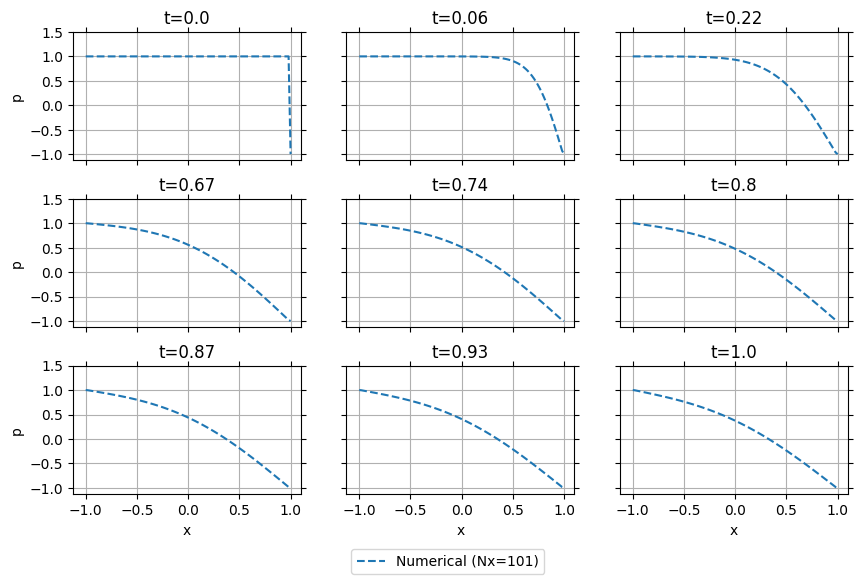

In [15]:
# model.compile("numerical", "FDM", True, "Numerical (Nx=101)")
model.run(**run_config)
print(model.get_df(columns=['time'],scale=True))
model.plot(True, True)

[Info] Case: Analytical (N=200) was added.


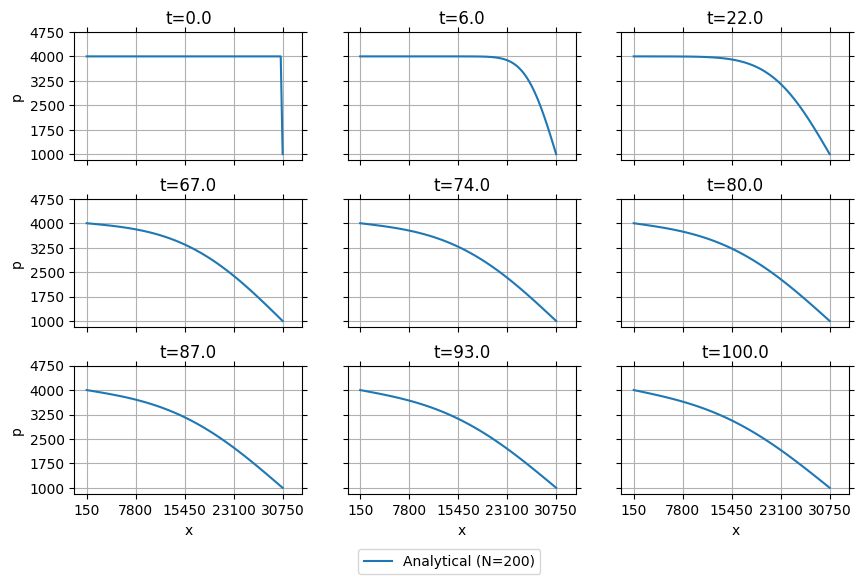

[Info] Case: Numerical (Nx=101) was added.


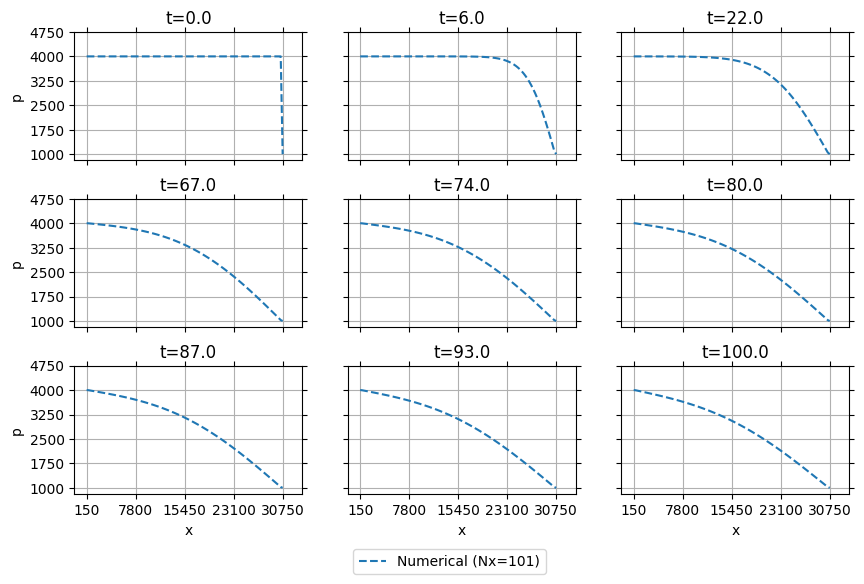

In [16]:
model.plot(name="Analytical (N=200)")
model.plot(name="Numerical (Nx=101)")

[Info] Case: Analytical (N=200) was added.
[Info] Case: Numerical (Nx=101) was added.


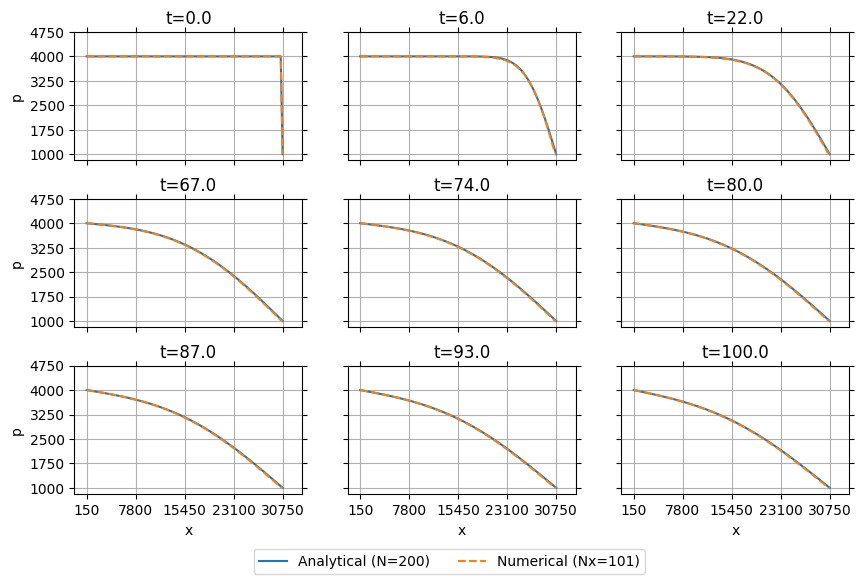

In [17]:
model.plot(
    scale=False,
    name="all",
)

[Info] Case: Analytical (N=200) was added.
[Info] Case: Numerical (Nx=101) was added.


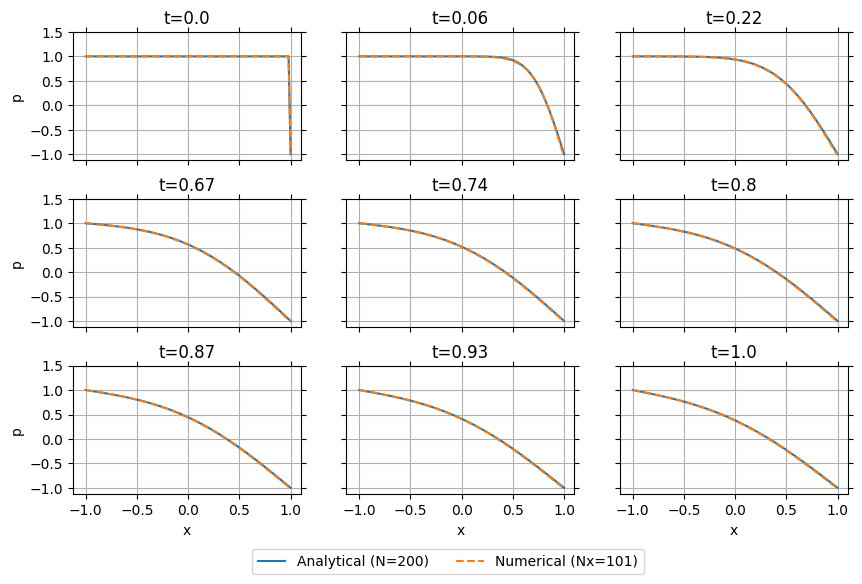

In [23]:
model.plot_solutions(
    scale=True,
    boundary=True,
)

In [19]:
model.get_df(
    melt=True,
    columns=["time", "cells_pressure"],
    scale=False,
    boundary=True,
    drop_nan=False,
)

,id,Step,x,Time,P
0,0,0,150.0,0,4000.000000
1,1,0,450.0,0,4000.000000
2,2,0,750.0,0,4000.000000
3,3,0,1050.0,0,4000.000000
4,4,0,1350.0,0,4000.000000
...,...,...,...,...,...
10398,98,100,29550.0,100,1166.329151
10399,99,100,29850.0,100,1118.853160
10400,100,100,30150.0,100,1071.330557
10401,101,100,30450.0,100,1023.779964


In [20]:
model.get_shape(True)

(101, 103)

In [21]:
    df = model.get_df(
        melt=True,
        columns=["time", "cells_pressure"],
        scale=True,
        boundary=True,
        drop_nan=False,
    )
    shape = model.get_shape(True)
    arr = df[["Time", "x", "P"]].values.reshape(*shape, 3)
    X = arr[:, :, :2]
    Y = arr[:, :, 2]

In [22]:
import numpy as np


def logarithmic_scaling(x, min_range, max_range, c=1):
    scaled_value = (
        (np.log(x + c) - np.log(X.min() + c))
        / (np.log(X.max() + c) - np.log(X.min() + c))
    ) * (max_range - min_range) + min_range
    return scaled_value


# Example usage
X = np.array([1, 10, 100, 1000])

min_range = 0  # Replace with your desired minimum range
max_range = 1  # Replace with your desired maximum range

scaled_X = logarithmic_scaling(X, min_range, max_range)

print(scaled_X)


def inverse_logarithmic_scaling(scaled_value, min_range, max_range, c=1):
    original_value = (
        np.exp(
            (
                (scaled_value - min_range)
                * (np.log(X.max() + c) - np.log(X.min() + c))
                / (max_range - min_range)
            )
            + np.log(X.min() + c)
        )
        - c
    )
    return original_value


# Example usage
scaled_X = np.array([0, 0.5, 0.8, 1])  # Replace with your scaled values
min_range = 0  # Replace with your specified minimum range
max_range = 1  # Replace with your specified maximum range

original_X = inverse_logarithmic_scaling(scaled_X, min_range, max_range)

print(original_X)

[0.  0.3 0.6 1. ]
[   1.    43.7  287.8 1000. ]


```{include} /_static/comments_section.md
```